In [1]:
from random import random, randint, seed
from joblib import Parallel, delayed

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/scratch/sekiz/Mlip/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from matplotlib.pyplot import imshow
%matplotlib inline

## Adding Noise to Data

This is a parallelized version of noise function in [Joan's toolkit ](https://github.com/simgeekiz/MLIP/blob/master/progress/Joan/toolkit/noise.py#L19). Full version of the noisy data was created and saved by runing the script add_noise.py.

In [74]:
def add_noisy_pixels_image(img, prob):
    return [randint(0,255) if random() < prob else img[i] for i, _ in enumerate(img)]

In [75]:
def add_noisy_pixels(X, prob, sd=1, n_jobs=10):
    seed(sd)

    if isinstance(X, pd.DataFrame):
        X_noisy = pd.DataFrame(Parallel(n_jobs=n_jobs)(delayed(add_noisy_pixels_image)(img, prob) for _, img in X.iterrows()),
                               columns=X.columns.values)
    else:
        raise ValueError('Unsupported type')
        
    return X_noisy

In [77]:
X_train_noisy = add_noisy_pixels(X_train[:10], 0.6, sd=1, n_jobs=15)

##### Sample Image

In [83]:
sample_index = randint(0, X_train_noisy.shape[0])

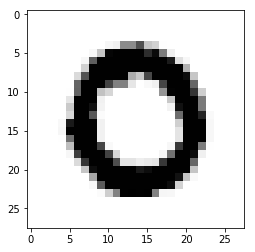

In [84]:
clean_sample = X_train.iloc[sample_index]
imshow(clean_sample.values.reshape((28, 28)), cmap='Greys')

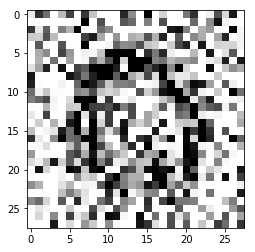

In [85]:
noisy_sample = X_train_noisy.iloc[sample_index]
imshow(noisy_sample.values.reshape((28, 28)), cmap='Greys')

## Load the data

There are 3 versions of the data depending on the noise; for clean data give `''`, for noisy data generated by above functions give `'_noisy'`, for data under Joan's folder give `'Joan'`

In [20]:
noisiness = '_noisy' # options; '', _noisy', 'Joan'

In [22]:
train_path = '../Joan/data/train.csv' if noisiness == 'Joan' else 'data/train{}.csv'.format(noisiness)
train = pd.read_csv(train_path)

test_path = '../Joan/data/test.csv' if noisiness == 'Joan' else 'data/test{}.csv'.format(noisiness)
test = pd.read_csv(test_path)

y_train = train.pop('label')
X_train = train

del train

## Preprocessing

##### Normalization

In [9]:
X_train = X_train/255.0
test = test/255.0

##### Reshaping

In [ ]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

##### One hot encoding

In [11]:
y_train = to_categorical(y_train, num_classes = 10)

## Splitting

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1,
                                                  random_state=42)

## Optimizer

In [13]:
optimizer = Adam()

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

## Network

In [15]:
epochs = 30
batch_size = 86

In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                 activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(10, activation = "softmax", name = "Output_Layer"))

Alternative simple 5 hidden layered network that tried before the above model. Got 98.26 accuracy at maximum on original Kaggle data. Takes approximately 15 minutes to train. Data should not be reshaped to use this one;
```
model = Sequential()
model.add(Dense(300, activation = "relu", input_shape=X_train.shape[1:]))
model.add(Dropout(0.25))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax", name = "Output_Layer"))
```

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Compiling

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## Data Augmentation

## Fitting

In [ ]:
model_history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          verbose=2,
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          callbacks=[learning_rate_reduction])

## Prediction on Test

In [ ]:
results = model.predict(test)

##### Save for submission

In [ ]:
results = np.argmax(results, axis = 1)
results = pd.Series(results, name='Label')
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'),results],axis = 1)
submission.to_csv("data/results/keras_conv{}_submission_jupyter.csv".format(noisiness),index=False)